[논문]
U-Net : Convolutional Networks for Biomedical Image Segmentation

### 0. Abstract
의료 계열에서의 두가지 문제 상황 해결을 위해 나온 논문

1. 데이터의 부족문제
의료계열 특성상 data 수 부족
→ 개인정보 등에 의한 민감한 문제로 training data 구하기 어렵고,
    구해도 레이블링을 하기 위해서는 전문가들이 직접 해야함

2. 같은 클래스가 인접한 셀 구분이 어려운데, 단순 세그멘테이션은 이를 수행하기 어려움

### 1. Introduction
Visual Recognition 분야에서 딥러닝 모델 성능의 향상 → Biomedical 분야에 적용 시도

Biomedical image processing 분야의 경우 각각의 픽셀이 클래스를 가지는 "localization" 필요
→ Biomedical의 특성상 학습 데이터의 수가 많이 부족
    (전문가가 라벨링, 환자의 데이터이기 때문에 라벨된 이미지의 수 부족)
→ 한계를 극복하기 위해 Ciresan [1]의 경우 Sliding Window 방식 도입

[Sliding Window의 장점]
- Localize 가능
- Patch 단위의 학습을 할 경우 데이터의 양 증가
- EM segmentation challenge로 좋은 결과 출력

Sliding Window는 중앙 하나의 픽셀에 대해서만 "Classification"을 수행

[Sliding Window의 문제점]
- Patch에 대해 학습 하기에 속도 느림, 많은 영역이 겹치는 부분 생김
- Localization 정확도와 context의 사용간에 trade-off 존재
	- Patch가 크면, 주변정보도 같이 학습○
	  → 이미지의 크기를 줄이기 위해 많은 Pooling 필요 → localization 정확도 감소
	- Patch가 작으면, sub sampling에 의한 정보 손실 감소
	  → context만 보는 문제점 생김
	※ classifier의 output을 multiple layer의 features로 고려해서
	   Good Localization과 use of context 가능

[해결방법] - Sliding Window 사용
- 1개의 픽셀만이 아닌 Patch영역을 Classification하는 특징
- 전체 영역을 다 예측하는게 아닌 padding을 0으로 설정
(572의 입력이 들어올때 1개의 픽셀이 아닌 388의 픽셀을 예측)
→ Overlap-tile 전략
	- fully connected layers를 사용하지않고, 오직 convolution만 사용
	  (Overlap tile을 통해 임의의 이미지를 입력받아도 문제없게 함)
	- 큰 이미지를 한정된 GPU에서 학습

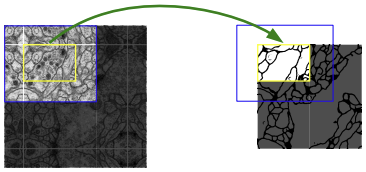
$$ 그림2 $$
그림2에서 파란색 영역이 들어와서, 노란색 영역이 출력 나옴.
노란색 출력과 초록색 출력 부분이 겹치지 않기에 Overlap tile이라고 불림
- U-Net의 경우
572의 입력을 388까지 줄이기에 외각 부분(92칸)의 예측을 수행시에 손실되는 부분 생김
→ 이를 해결하기위해 외각부분에 대해 Mirror padding 적용
    (입력 이미지를 미러링하여 누락된 부분을 추정)


### 2. Network
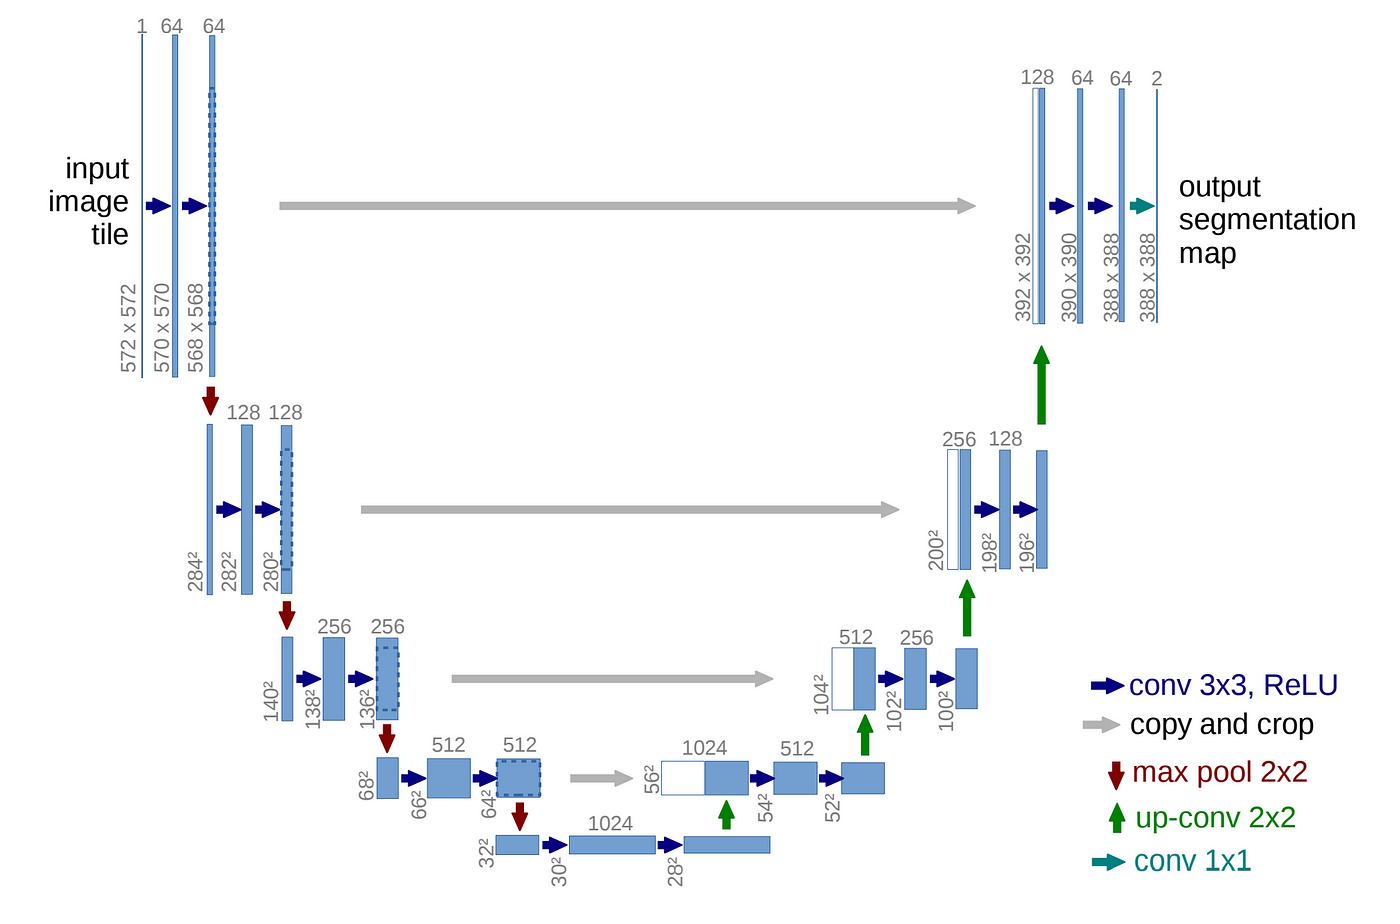
- Unet : FCN을 확장한 U 모습의 네트워크
	- 적은 학습 데이터로 높은 성능
	- FCN의 Contracting network를 이용하여 출력의 Resolution을 증가시키는 방법 사용

Upsampling할 때, 채널의 수를 크게함으로서 context information을 높은 resolution layer에 전파
FC Layer을 제거하고 Convolution만을 이용하여 Overlap tile 전략에 의해 임의의 크기의 이미지가 들어와도 Segmentation이 가능하게 함.

결론적으로 인코더(Contracting Path)와 디코더(Expanding Path) 대칭이고 U-shape의 모양을 가짐

==============================================================================
### ※ U-net의 구조

#### 1. 입력 레이어
- 입력 이미지 타일 : 572 * 572 입력 이미지 크기 1개의 채널을 가진 흑백 이미지

#### 2. 인코더 (Contracting Path)
입력 이미지의 context 포착을 목적으로 구성
FCNs처럼 VGG-based 아키텍처

- 컨볼루션 레이어 (conv 3 * 3, ReLU)
: 각 레이어에 3 * 3 크기의 커널을 사용한 컨볼루션을 수행, ReLU 활성화 함수를 통해 비선형성 추가
- 맥스 풀링 (max pool 2 * 2)
: 각 컨볼루션 레이어 뒤에 2 * 2 맥스 풀링이 적용
(특징 맵의 해상도를 절반 = 중요한 정보를 유지하면서 공간적 차원 줄임)

572 * 572 크기의 이미지(1개의 채널(흑백 이미지)) =========> 특징 맵 조금씩 왜 줄지? 패딩 없어서
→ 3 * 3 컨볼루션
570 * 570 크기의 이미지(64 필터)
→ 3 * 3 컨볼루션
568 * 568 크기의 이미지(64 필터)
→ 2 * 2 맥스 풀링

284 * 284 크기의 이미지(64 필터)
→ 3 * 3 컨볼루션
282 * 282 크기의 이미지(128 필터) =========> 다운샘플링 마다 채널의 수 2배 증가
→ 3 * 3 컨볼루션
280 * 280 크기의 이미지(128 필터)
→ 2 * 2 맥스 풀링

*
*
*

32 * 32 크기의 이미지(512 필터)
→ 3 * 3 컨볼루션
30 * 30 크기의 이미지(1024 필터)
→ 3 * 3 컨볼루션
28 * 28 크기의 이미지(1024 필터)

#### 3. 병목 (Bottleneck)
인코더와 디코더 연결하는 단계(가장 낮은 해상도의 특징 맵 생성)
- 병목 시작 : 28 * 28 상태에서 컨볼루션 수행하거나 추가적인 연산을 통해 정보 압축
- 병목 후 : 디코더 시작, 업샘플링을 통해 해상도 다시 복원

#### 4. 디코더 (Expanding Path)
세밀한 Localization을 위한 구성
높은 차원의 채널을 갖는 업샘플링, 얕은 레이어의 특징맵을 결합

- 업샘플링 (up-conv 2 * 2)
: 업샘플링을 통해 특징 맵의 해상도를 높임
- 복사 및 자르기 (copy and crop)
: 인코더에서의 스킵 연결을 위해, 인코더의 특징 맵을 디코더의 대응하는 레이어와 연결
(세밀한 정보를 보존하는데 중요!!)

28 * 28 크기의 이미지(1024 필터)
→ 2 * 2 업샘플링
→ copy and crop

56 * 56(1024 필터)
→ 3 * 3 컨볼루션
54 * 54(512 필터) =========> 업샘플링마다 채널의 수 절반 줄어듬
→ 3 * 3 컨볼루션
52 * 52(512 필터)
→ 2 * 2 업샘플링
→ copy and crop

104 * 104(512 필터)
→ 3 * 3 컨볼루션
102 * 102(256 필터)
→ 3 * 3 컨볼루션
100 * 100(256 필터)
→ 2 * 2 업샘플링
→ copy and crop

*
*
*

392 * 392(128 필터)
→ 3 * 3 컨볼루션
390 * 390(64 필터)
→ 3 * 3 컨볼루션
388 * 388(64 필터)
→ 1 * 1 컨볼루션
388 * 388(2 필터) =========> 최종적인 분할 맵!!(각 픽셀에 대한 클래스 확률 포함)

#### 5. 출력 레이어
- 최종 분할 맵 : 각 픽셀에 대한 클래스 확률 포함
	- 소프트 맥스 or 시그모이드 활성화를 사용해 각 픽셀의 클래스 확률 계산
	- 이진 분할 : 시그모이드 활성화 함수를 사용해 픽셀이 특정 클래스에 속할 확률 계산
	- 다중 클래스 분할 : 소프트 맥스 활성화 함수를 사용해 여러 클래스에 대한 확률 계산